In [1]:
import sys; sys.path.append("..")
from model import Dataset, ELM2D
d = next(iter(Dataset("ks2d_short.npy")))

In [2]:
N0, N1 = d.shape[1:]
maxval, minval = d.max(), d.min()
normalize = lambda x: (x-minval)/(maxval-minval)
denormalize = lambda x: x*(maxval-minval)+minval
D = [normalize(d)]

In [3]:
from tqdm.notebook import tqdm 

extent = 2
step = 4
hidden = 400 
errors_one_symmetry = [[] for _ in range(8)]
X_test = normalize(d[-2,None,...])
Y_test = normalize(d[-1,None,...])

model = ELM2D((extent,extent),(step,step),hidden)
symmetries = list(range(8))
pbar = tqdm(symmetries)

def callback(k, model, sym):
    Y_pred = model(X_test, nr_symmetries=1).detach()
    err = (Y_test - Y_pred).abs().mean()
    errors_one_symmetry[sym].append(err.item())
    Y_pred = model(X_test, nr_symmetries=8).detach()
    err = (Y_test - Y_pred).abs().mean()
    pbar.set_description(f"{errors_one_symmetry[sym][-1]:.5f}")

for sym in pbar:
    cb = lambda k,_, model: callback(k, model, sym)
    model.train(D, nr_symmetries=sym+1, stopping_threshold=1e-3, noise=1e-5, callback=cb)


  0%|          | 0/8 [00:00<?, ?it/s]

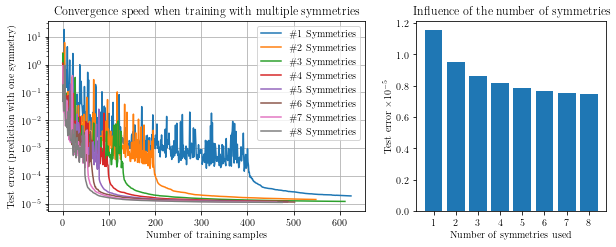

In [5]:
import matplotlib.pyplot as plt 
import numpy as np

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
})

fig, ax = plt.subplots(1,2,figsize=(10,3.5),width_ratios=[1,0.6],gridspec_kw={"wspace":.2})
for sym, r in enumerate(errors_one_symmetry):
    x = np.arange(len(r))
    ax[0].plot(x, np.array(r), label=f"\#{sym+1} Symmetries")
ax[0].set_yscale("log")
ax[0].legend()
ax[0].set_ylabel("Test error (prediction with one symmetry)")
ax[0].set_xlabel("Number of training samples")
ax[0].set_title("Convergence speed when training with multiple symmetries")
ax[0].grid()

errors_by_symmetries = []
for sym in range(8):    
    Y_pred = model(X_test, nr_symmetries=sym+1).detach()
    err = (Y_test - Y_pred).abs().mean() * 10**(+5)
    errors_by_symmetries.append(err.item())
    
ax[1].bar(x=[i+1 for i in range(8)],height=errors_by_symmetries)
ax[1].set_ylabel("Test error $\\times 10^{-5}$")
ax[1].set_xlabel("Number of symmetries used")
ax[1].set_xticks([i+1 for i in range(8)])
ax[1].set_title("Influence of the number of symmetries")

plt.savefig("plots/ks2d_symmetries.pdf", format="pdf", bbox_inches="tight")
plt.show()